In [6]:
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
from scipy.signal.windows import tukey
import scipy.signal as sl

from tqdm import tqdm 
from glob import glob

import os
import wget
from gwosc.timeline import get_segments
from gwosc.locate import get_urls

from slicgw.constants import *

import requests
import json

In [7]:
# define the instrument we want ('H1' for Hanford, 'L1' for Livingston)
ifo = 'H1'
save_dir = '/mnt/home/rlegin/ceph/gw/'
data_dir = '/mnt/home/rlegin/ceph/gw/raw_data/'

In [8]:
def read_data(path, **kws):
    with h5py.File(path, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
        dt = T/len(h)
        time = t0 + dt*np.arange(len(h))
        return pd.Series(h, index=time, **kws)

In [9]:
data_list = []
psd_set = []

for path in tqdm(sorted(glob(os.path.join(data_dir, '*.hdf5')))):
    
    full_data = read_data(path)
    
    no_nans = not full_data.isnull().values.any()
    
    if no_nans:
        # Welch data to get PSD, with settings to give an FFT length of 4s
        psd_freq, psd = sl.welch(full_data, fs=srate, nperseg=4*srate)
        psd_set.append(psd)

    data_list.append(full_data)

100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


In [10]:
N = len(psd_set)
psd_avg = np.add.reduce(psd_set) / N

In [70]:
np.save(os.path.join(save_dir, 'psd_avg.npy'), psd_avg)
np.save(os.path.join(save_dir, 'psd_freq.npy'), psd_freq)

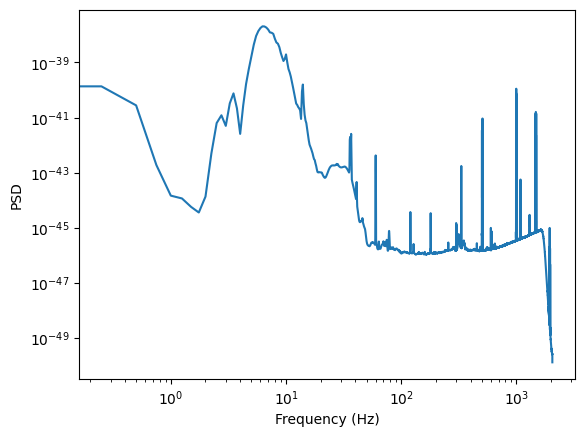

In [12]:
plt.loglog(psd_freq, psd_avg)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD");

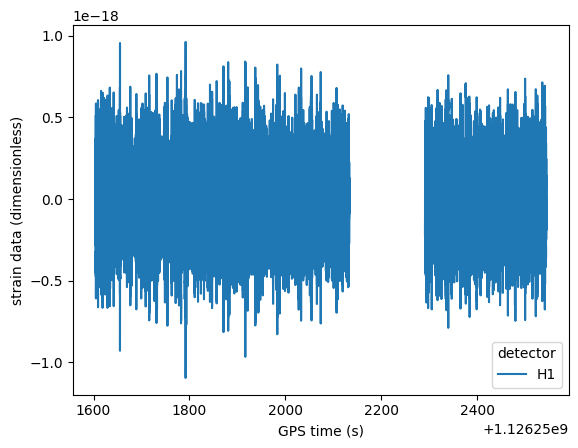

In [26]:
d = data_list[0]
epoch = d.index[0]
plt.plot(d, label=ifo)
plt.legend(title="detector", loc="lower right")
plt.xlabel("GPS time (s)")
plt.ylabel("strain data (dimensionless)");

In [ ]:
d

1.126248e+09             NaN
1.126248e+09             NaN
1.126248e+09             NaN
1.126248e+09             NaN
1.126248e+09             NaN
                    ...     
1.126253e+09   -1.962237e-20
1.126253e+09   -1.357275e-20
1.126253e+09   -2.460189e-20
1.126253e+09   -6.847398e-20
1.126253e+09   -2.896389e-20
Length: 16777216, dtype: float64

In [27]:
# duration of segment in seconds
T = 4

data_segments = []
for d in tqdm(data_list):
    # sampling interval
    dt = d.index[1] - d.index[0]
    # segment length
    N = int(round(T / dt))
    # number of segments
    N_segments = int(len(d) / N)
    data_segments += [d.iloc[k*N:k*N+N] for k in range(N_segments)]

100%|██████████| 10/10 [00:00<00:00, 46.58it/s]


In [28]:
print(dt)

0.000244140625


In [29]:
print(f"There are {len(data_segments)} {ifo} segments.")

There are 10240 H1 segments.


In [32]:
filename = 'gwosc_catalog.json'  # specify the filename of the JSON file

# # get detection catalog from GWOSC
# url = 'https://www.gw-openscience.org/eventapi/jsonfull/GWTC/'
# with requests.get(url) as r:
#     rjson = r.json()

with open(filename, 'r') as file:
    rjson = json.load(file)

true_event_times = sorted([v['GPS'] for v in rjson['events'].values()])

In [34]:
good_segments = []
#good_segments = np.zeros((len(data_segments), data_segments[0].shape[0]))
for s in tqdm(data_segments):
    no_events = all([(t0 < s.index[0] or t0 > s.index[-1]) for t0 in true_event_times])
    no_nans = not s.isnull().values.any()
    if no_events and no_nans:
        good_segments.append(s)

print(f"There are {len(good_segments)} good {ifo} segments.")

100%|██████████| 10240/10240 [00:01<00:00, 9052.22it/s]

There are 7825 good H1 segments.


In [61]:
whiten_scale_factor = 100
td_crop_index_start = 6000
td_crop_index_end = 6000+4096

In [71]:
Nsize = good_segments[0].shape[0]
w = tukey(Nsize, tukey_alpha)
f = np.fft.rfftfreq(Nsize, d=dt)

data_td_whiten_set = []
for data_td in good_segments:
    data_fd = np.fft.rfft(data_td*w)*dt
    data_fd_whiten = data_fd/np.sqrt(psd_avg)
    data_td_whiten = np.fft.irfft(data_fd_whiten) / dt
    data_td_whiten = data_td_whiten[td_crop_index_start:td_crop_index_end]/whiten_scale_factor
    data_td_whiten_set.append(np.array(data_td_whiten, dtype=np.float32))

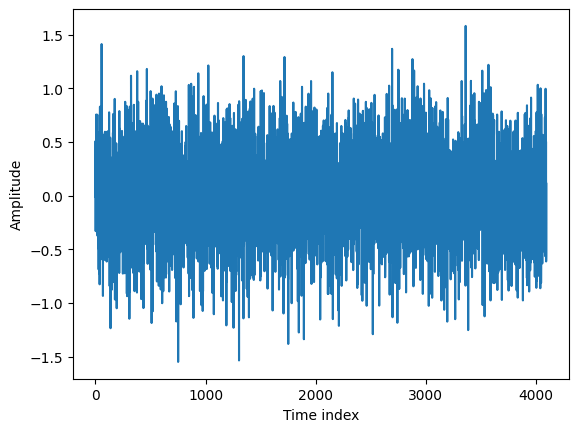

In [72]:
plt.plot(data_td_whiten_set[0])
plt.xlabel("Time index")
plt.ylabel("Amplitude");

In [73]:
h5f = h5py.File(os.path.join(save_dir, 'trainH_td.h5'), 'w')
h5f.create_dataset('data', data=np.array(data_td_whiten_set, dtype=np.float32))
h5f.close()

In [23]:
# def get_data_fd(d):
#   Nsize = d.shape[0]
#   w = tukey(Nsize, tukey_alpha)
#   f = np.fft.rfftfreq(Nsize, d=dt)
#   data_fd = pd.Series(np.fft.rfft(d*w)*dt, index=f)
#   return data_fd, f, dt

# def preprocess_data(data_fd, hz_cut=20, rescale_factor=1e-23):
#   f = np.array(data_fd.index)
#   amp = np.array(data_fd.array)
#   amp[f < hz_cut] = 0.
#   return amp[1:]/rescale_factor # Remove zero frequency to make resolution 8192 instead of 8193 and rescale data by constant

# def get_training_data(segments):
#   training_data = []
#   for segment in segments:
#     data_fd, f, dt = get_data_fd(segment)
#     data = preprocess_data(data_fd, hz_cut=20., rescale_factor=1e-23)
#     data = np.array([data.real, data.imag]).astype('float32')
#     training_data.append(data)
#   return np.array(training_data)